In [10]:
# import libraries

import numpy as np
import pandas as pd
import os
from tqdm import tqdm


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from scipy.integrate import odeint, solve_ivp
from scipy.fft import fft


import matplotlib.pylab as plt
import seaborn as sns
import mpl_interactions.ipyplot as iplt
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import Sequence
from tensorflow import keras

import shap as shap
try:
    import lime
    import lime.lime_tabular    
except ImportError:
    pass

# Enable Jupyter Notebook's intellisense
%matplotlib inline
%matplotlib notebook
from ipywidgets import *
import matplotlib
import matplotlib.pyplot as plt

# for reproducibility of this notebook:
rng = np.random.RandomState(42)
#tf.random.set_seed(42)
np.random.seed(42)

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [2]:
class Duffing():
    """
        Class for the Duffing Oscillator
    """
    def __init__(self, parameters = {'alpha': 0.3, 'beta': -0.1, 'gamma': 0.37, 'delta': 0.3, 'omega': 1.2}, labels = ['xt','vt'], features = ['x0','v0','t','rand'], scaler = None):
        """
            Define Parameter Configuration to Model

            Parameters
            ----------
            alpha : float, linear stiffness
            beta  : float, non linearity in the restoring force
            gamma : float, amplitude of the periodic driving force
            delta : float, amount of damping
            omega : float, angular frequency of the periodic driving force
        """   
        self.parameters = parameters
        self.labels = labels
        self.features = features
        self.scaler = scaler
        self.suffix = "params_"+str(parameters['alpha'])+"_"+str(parameters['beta'])+"_"+str(parameters['gamma'])+"_"+str(parameters['delta'])+"_"+str(parameters['omega'])

    def eom(self, t, u):
        """
            Duffing Oscillator Equation of Motion

            ddx + delta * dx + alpha * x + beta * x**3 = gamma * cos(omega * t)

            Input
            ----------
            u : vector of length 2, (x,v)
                Position and Velocity at time t
            t : float, the time t

            Returns
            ----------
            [dx,ddx] : Tuple, Time derivatives of 
                        position and velocity at time t
        """
        x, dx = u[0], u[1]
        ddx = (self.parameters['gamma'] * np.cos(self.parameters['omega'] * t) - (self.parameters['delta'] * dx + self.parameters['alpha'] * x + self.parameters['beta'] * x**3))

        return [dx,ddx]

    def termination_event(self, t, y):
        """
            Stops Numerical Integration once points wander too far away
        """
        return (np.abs(y[0]) - 10)*(np.abs(y[1]) - 10)
    termination_event.terminal = True


    def generate(self, num_samples = int(5e1), samples=10, end_time=100, gridded=False):
        """
            Generates training samples using scipy.integrate.odeint
            to calculate the temporal evolution of a Duffing system.
    
            Samples randomly from x0 in [-2,2], v0 in [-1,1].
    
            For each set of initial conditions we generate a trajectory.
            The trajectory is randomly sampled to generate training
            pairs: X = (x0,v0,t), y = (xt,vt)
    
            Input
            ----------
            num_samples : int, number of training
                            samples to be generated
    
            Returns
            ----------
            X : array((num_samples,3)), each entry in the array
                is a training sample (x0,v0,t)
            y : array((num_samples,2)), each entry in the array
                is a target sample (xt,vt)
        """
            
        #Define bounds of the sampling
        x_min = -2
        x_max = 2
        v_min = -2
        v_max = 2
        #Initialise the output arrays        
        X = np.empty((num_samples*(samples), len(np.hstack((self.features, self.labels)))))
        #Define the t_range to draw from
        t_range = np.linspace(0, end_time, 100, endpoint=False)
        t_vals = np.sort(np.random.choice(t_range, size = samples, replace=False))
        if gridded:
            x_range = np.linspace(x_min, x_max, int(np.sqrt(num_samples)), endpoint = True)
            v_range = np.linspace(v_min, v_max, int(np.sqrt(num_samples)), endpoint = True)
            #Generate num_samples samples
            for i, x0 in tqdm(enumerate(x_range), desc="Generating Data…", ascii=False, ncols=75):
                for v0 in v_range:
                    #Generate a trajectory
                    trajectory = solve_ivp(self.eom, [0, end_time], [x0,v0], t_eval = t_vals, events = [self.termination_event])
                    traj_cutoff =  samples - len(trajectory.y[0])
                    if traj_cutoff > 0:
                        trajectory.y[0] = np.append(trajectory.y[0].reshape(-1,1), 10.0*np.ones(traj_cutoff))
                        trajectory.y[1] = np.append(trajectory.y[1].reshape(-1,1), 10.0*np.ones(traj_cutoff))
                    X[i*samples:(i+1)*samples,:] = np.hstack((x0*np.ones(samples).reshape(-1,1), 
                                                        v0*np.ones(samples).reshape(-1,1), 
                                                        t_vals.reshape(-1,1), 
                                                        np.random.uniform(-1,1,samples).reshape(-1,1),
                                                        trajectory.y[0].reshape(-1,1), 
                                                        trajectory.y[1].reshape(-1,1)))

        else:
            #Generate num_samples samples
            for i in tqdm(range(num_samples), desc="Generating Data…", ascii=False, ncols=75):
                #Generate random starting positions
                x0 = (x_max - x_min) * np.random.random_sample() + x_min
                v0 = (v_max - v_min) * np.random.random_sample() + v_min 
                #Generate a trajectory
                trajectory = solve_ivp(self.eom, [0, end_time], [x0,v0], t_eval = t_vals, events = [self.termination_event])
                traj_cutoff =  samples - len(trajectory.y[0])
                if traj_cutoff > 0:
                    x_traj = np.vstack((trajectory.y[0].reshape(-1,1), 10.0*np.ones(traj_cutoff).reshape(-1,1)))
                    v_traj = np.vstack((trajectory.y[1].reshape(-1,1), 10.0*np.ones(traj_cutoff).reshape(-1,1)))
                    X[i*samples:(i+1)*samples,:] = np.hstack((x0*np.ones(samples).reshape(-1,1), 
                                                            v0*np.ones(samples).reshape(-1,1), 
                                                            t_vals.reshape(-1,1), 
                                                            np.random.uniform(-1,1,samples).reshape(-1,1),
                                                            x_traj, 
                                                            v_traj))
                else:
                    X[i*samples:(i+1)*samples,:] = np.hstack((x0*np.ones(samples).reshape(-1,1), 
                                                            v0*np.ones(samples).reshape(-1,1), 
                                                            t_vals.reshape(-1,1), 
                                                            np.random.uniform(-1,1,samples).reshape(-1,1),
                                                            trajectory.y[0].reshape(-1,1), 
                                                            trajectory.y[1].reshape(-1,1)))
        
        self.X_df = pd.DataFrame(X, columns = np.hstack((self.features, self.labels)))
        return self.X_df

    def scale_features(self):
        if self.scaler == None:
            self.scaler = MinMaxScaler(feature_range=[0,1])
            self.X_df[self.features] = self.scaler.fit_transform(self.X_df[self.features].values)
        else: return


In [16]:
"""
Define Parameter Configuration to Model

    Parameters
    ----------
    alpha : float, linear stiffness
    beta  : float, non linearity in the restoring force
    gamma : float, amplitude of the periodic driving force
    delta : float, amount of damping
    omega : float, angular frequency of the periodic driving force
"""   
alpha = -1.0
beta = 1.0
gamma = 0.37
delta = 1.0
omega = 1.2

parameters_now = {'alpha': alpha, 'beta': beta, 'gamma': gamma, 'delta': delta, 'omega':omega}
duffing = Duffing(parameters = parameters_now)
eom = duffing.eom
suffix = duffing.suffix

In [17]:
end_time = 100
duffing.generate(100000, samples = 100, end_time = end_time)
duffing.scale_features()
X = duffing.X_df[duffing.features]
y = duffing.X_df[duffing.labels]

Generating Data…: 100%|████████████| 100000/100000 [50:56<00:00, 32.72it/s]


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [19]:
"""
Define and Create Model
"""

def MLModel():
    opt = Adam(learning_rate=0.001, beta_1=0.7)
    loss='mse'
    model = Sequential([
        layers.Flatten(),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='sigmoid'),
        layers.Dense(32, activation='tanh'),
        layers.Dense(2)            
    ])
    model.compile(optimizer=opt, loss=loss)
    return model

# Create a basic model instance
model = MLModel()

In [20]:
"""
Train Model
"""
#model.build()
# Display the model's architecture
#model.summary()



# Create a callback that saves the model's weights
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25),
             tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25)]


# pipe = make_pipeline(scaler, model)

history=model.fit(X_train, y_train, steps_per_epoch=None, epochs=500, 
                  validation_split=0.2, batch_size=1024, shuffle=True, callbacks=callbacks, verbose=1)

loss = model.evaluate(X_test, y_test, verbose=1)
print("Trained model, loss: {:5.2f}%".format(loss))

Epoch 1/500
7032/7032 [==============================] - 56s 8ms/step - loss: 0.0762 - val_loss: 0.0690
Epoch 2/500
7032/7032 [==============================] - 55s 8ms/step - loss: 0.0572 - val_loss: 0.0567
Epoch 3/500
7032/7032 [==============================] - 56s 8ms/step - loss: 0.0502 - val_loss: 0.0459
Epoch 4/500
7032/7032 [==============================] - 57s 8ms/step - loss: 0.0454 - val_loss: 0.0535
Epoch 5/500
7032/7032 [==============================] - 59s 8ms/step - loss: 0.0390 - val_loss: 0.0332
Epoch 6/500
7032/7032 [==============================] - 57s 8ms/step - loss: 0.0328 - val_loss: 0.0282
Epoch 7/500
7032/7032 [==============================] - 55s 8ms/step - loss: 0.0269 - val_loss: 0.0327
Epoch 8/500
7032/7032 [==============================] - 57s 8ms/step - loss: 0.0205 - val_loss: 0.0130
Epoch 9/500
7032/7032 [==============================] - 55s 8ms/step - loss: 0.0142 - val_loss: 0.0084
Epoch 10/500
7032/7032 [==============================] - 55s 8m

31250/31250 [==============================] - 32s 1ms/step - loss: 0.0055
Trained model, loss:  0.01%


In [21]:
"""
Evaluate Model
"""

# evaluate the fitting validation and training losses
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

## Make Prdictions on the Test Dataset
y_pred = pd.DataFrame(model.predict(X_test), columns=['xt','vt'])

pred_norm = np.linalg.norm(y_pred[['xt','vt']].values,axis=1)
true_norm = np.linalg.norm(y_test[['xt','vt']].values,axis=1)
hist_data = np.abs(pred_norm-true_norm)/np.abs(true_norm)
hist_data = pd.DataFrame(hist_data, columns=['norm'])

def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.00)
    Q3 = df.quantile(0.95)
    IQR = Q3 - Q1
    trueList = ~((df > (Q3 + 1.5 * IQR)))
    #trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

indices = Remove_Outlier_Indices(hist_data)
hist_data = hist_data[indices]

<IPython.core.display.Javascript object>


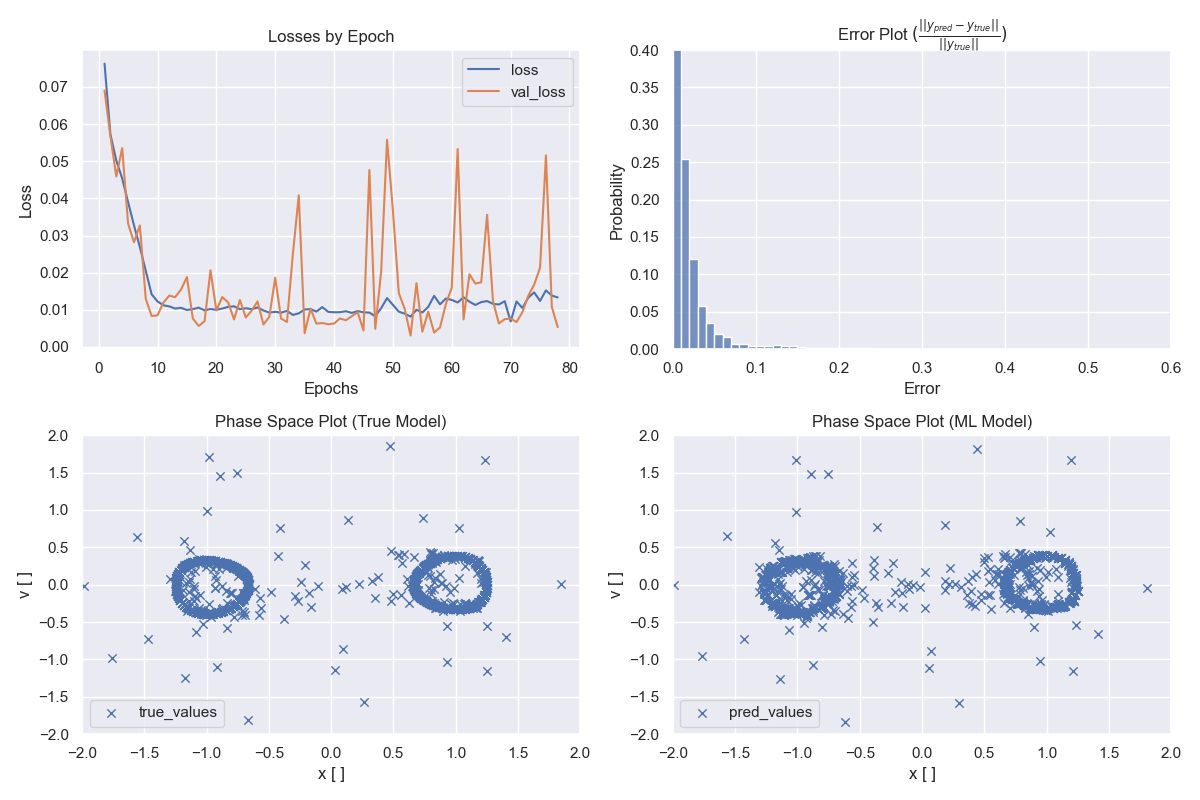

You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [23]:
# Loss Plot ML Model
f, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4, 4]))

sns.lineplot(data = history.history, x = epochs, y='loss',ax=axs[0,0], label='loss')
sns.lineplot(data = history.history, x = epochs, y='val_loss',ax=axs[0,0], label='val_loss')

axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title("Losses by Epoch")
axs[0,0].legend()

# Error Plot for ML Predictions
sns.histplot(data=hist_data, x = 'norm', kde=False, stat='probability', binwidth=0.01, ax=axs[0,1])

axs[0,1].set(xlim=(0, 0.6), ylim=(0, 0.4))
axs[0,1].set_xlabel('Error')
axs[0,1].set_ylabel('Probability')
axs[0,1].set_title(r"Error Plot $(\frac{||y_{pred}-y_{true}||}{||y_{true}||})$")

# True Values Plot
sns.scatterplot(data = y_test.iloc[:2000,:], x = 'xt', y='vt',ax=axs[1,0],label='true_values', marker='x', linewidth = 1)

axs[1,0].set(xlim=(-2, 2), ylim=(-2, 2))
axs[1,0].set_xlabel('x [ ]')
axs[1,0].set_ylabel('v [ ]')
axs[1,0].set_title("Phase Space Plot (True Model)")

# ML Values Plot
sns.scatterplot(data = y_pred.iloc[:2000,:], x='xt', y='vt',ax=axs[1,1],label='pred_values',  marker='x', linewidth = 1)

axs[1,1].set(xlim=(-2, 2), ylim=(-2, 2))
axs[1,1].set_xlabel('x [ ]')
axs[1,1].set_ylabel('v [ ]')
axs[1,1].set_title("Phase Space Plot (ML Model)")

f.tight_layout()

f.savefig("Images/model_summary"+suffix+".svg", dpi='figure')

In [24]:
model.save("Models/ml_model_"+suffix)

INFO:tensorflow:Assets written to: Models/ml_model_params_-1.0_1.0_0.37_1.0_1.2\assets
